# Setup

In [1]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
require("pacman")
options(warn = -1)
pacman::p_load(tidyverse, lubridate, zoo, ggpubr, ggfortify, forecast, mgcv)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

Loading required package: pacman



# Splines Model


Family: gaussian 
Link function: identity 

Formula:
Value ~ s(as.numeric(Date)) + Quarter - 1

Parametric coefficients:
          Estimate Std. Error t value Pr(>|t|)    
QuarterQ1 65.55967    0.05666    1157   <2e-16 ***
QuarterQ2 65.63608    0.05662    1159   <2e-16 ***
QuarterQ3 65.60369    0.05662    1159   <2e-16 ***
QuarterQ4 65.56246    0.05666    1157   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                      edf Ref.df     F p-value    
s(as.numeric(Date)) 8.617  8.958 382.6  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.954   Deviance explained =  100%
GCV = 0.14555  Scale est. = 0.13462   n = 168

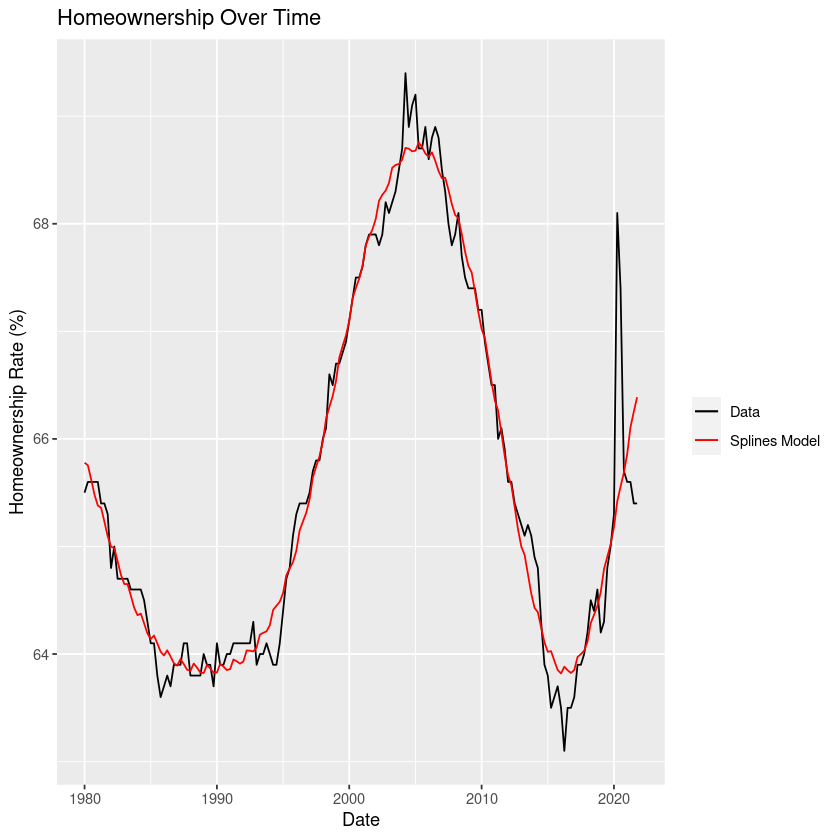

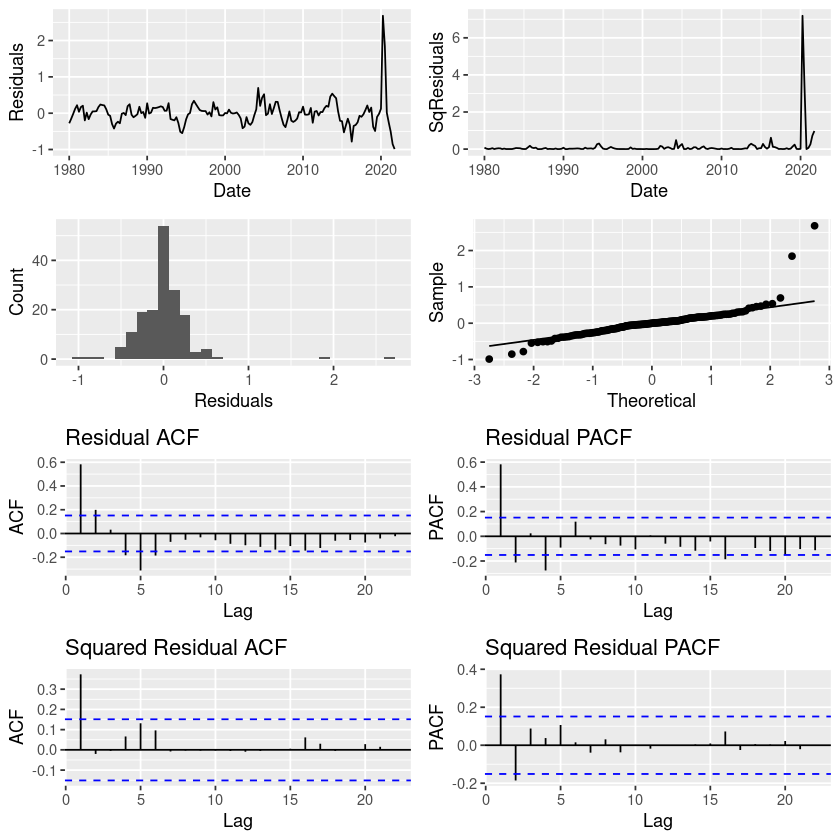

In [2]:
homeownership <- read_homeownership()

splines_model <- gam(Value ~ s(as.numeric(Date)) + Quarter - 1 , data = homeownership)

summary(splines_model)

homeownership %>% ggplot() + 
    geom_line(aes(x = Date, y = Value, color = "Data")) + 
    geom_line(aes(x = Date, y = fitted(splines_model), color = "Splines Model"))+
    labs(x = "Date", y = "Homeownership Rate (%)", title = "Homeownership Over Time") +
    scale_color_manual("", values = c("Data" = "black", "Splines Model" = "red"))

residual_analysis(splines_model, homeownership$Date)

In [3]:
splines_residuals <- data.frame(Date = homeownership$Date, Residuals = residuals(splines_model))
test_split <- 4
train <- splines_residuals %>% head(-test_split)
test <- splines_residuals %>% tail(test_split)

# Training ARIMA

In [4]:
arima_comp <- find_best_arima(train$Residuals, 0:5, 0:2, 0:5)
head(arima_comp)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,1,0,5,25.02675
2,4,0,3,26.88067
3,2,0,5,26.98166
4,3,0,5,29.00776
5,4,0,5,30.46397
6,5,0,5,31.45905



	Box-Ljung test

data:  residuals(model)
X-squared = 0.26928, df = 1, p-value = 0.6038


	Box-Ljung test

data:  residuals(model)^2
X-squared = 1.0712, df = 1, p-value = 0.3007



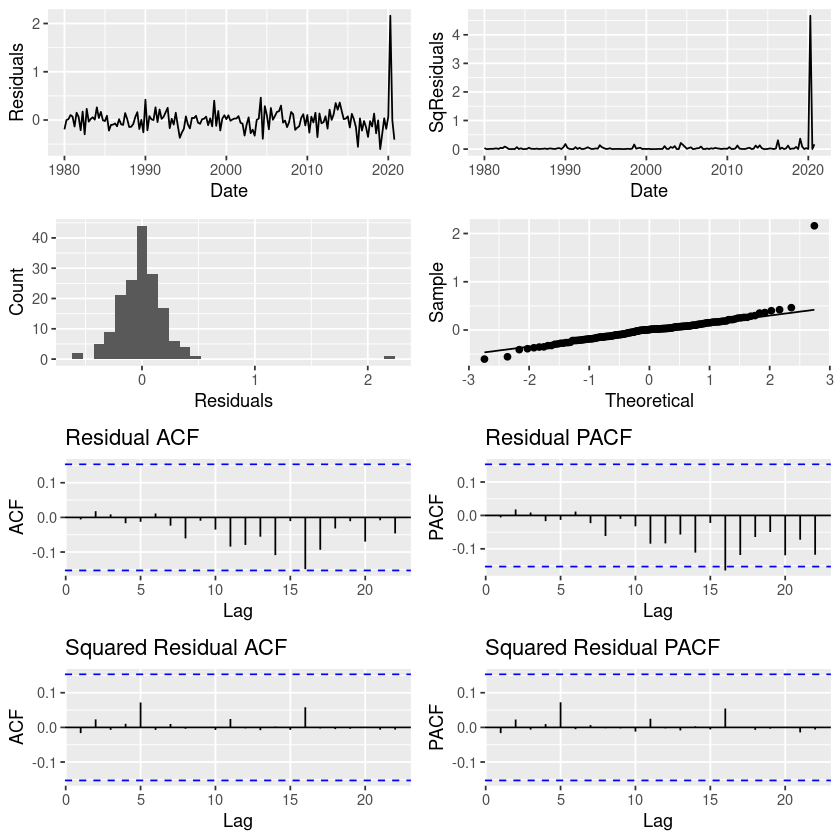

In [5]:
best_order <- as.numeric(arima_comp[1,1:3])
arima_model <- arima(train$Residuals, order = best_order, method = "ML", optim.control = list(maxit = 1000))
residual_analysis(arima_model, train$Date)
box_tests(arima_model, best_order[1] + best_order[3])

# Training ARMA-GARCH

In [6]:
ugarch_comp <- find_best_ugarch(splines_residuals$Residuals, best_order[1], best_order[3], 0:5, 0:5, 0:2, 0:2, test_size = test_split)
head(ugarch_comp$Final)

,p,q,m,n,BIC
,<int>,<int>,<int>,<int>,<dbl>
1,3,2,1,1,-0.4736145
2,3,2,2,0,-0.4735455
3,3,2,0,0,-0.2996119
4,3,2,0,1,-0.2813693
5,3,2,1,0,-0.2725603
6,3,2,1,2,-0.2569970


## Model 1: Best Orders


	Box-Ljung test

data:  residuals(model)
X-squared = 17.093, df = 1, p-value = 3.559e-05


	Box-Ljung test

data:  residuals(model)^2
X-squared = 3.4779, df = 1, p-value = 0.06219



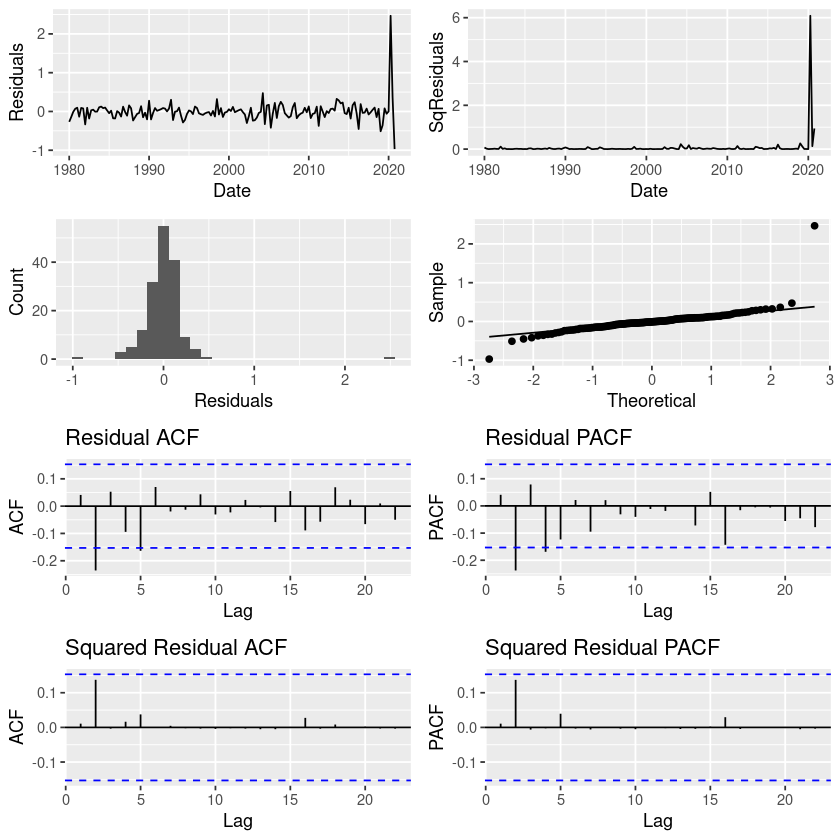

In [7]:
best_order <- ugarch_comp$Final[1,1:4] %>% as.numeric
spec1 <- ugarchspec(variance.model=list(garchOrder=c(best_order[3:4])),
                     mean.model=list(armaOrder=c(best_order[1:2]),
                                     include.mean=T), distribution.model="std")
ugarch_model1 <- ugarchfit(spec1, splines_residuals$Residuals, solver = 'hybrid', out.sample = test_split)
residual_analysis(ugarch_model1, train$Date)
box_tests(ugarch_model1, sum(best_order))

## Model 2: Forced GARCH(1,1)


	Box-Ljung test

data:  residuals(model)
X-squared = 18.049, df = 1, p-value = 2.153e-05


	Box-Ljung test

data:  residuals(model)^2
X-squared = 3.8387, df = 1, p-value = 0.05008



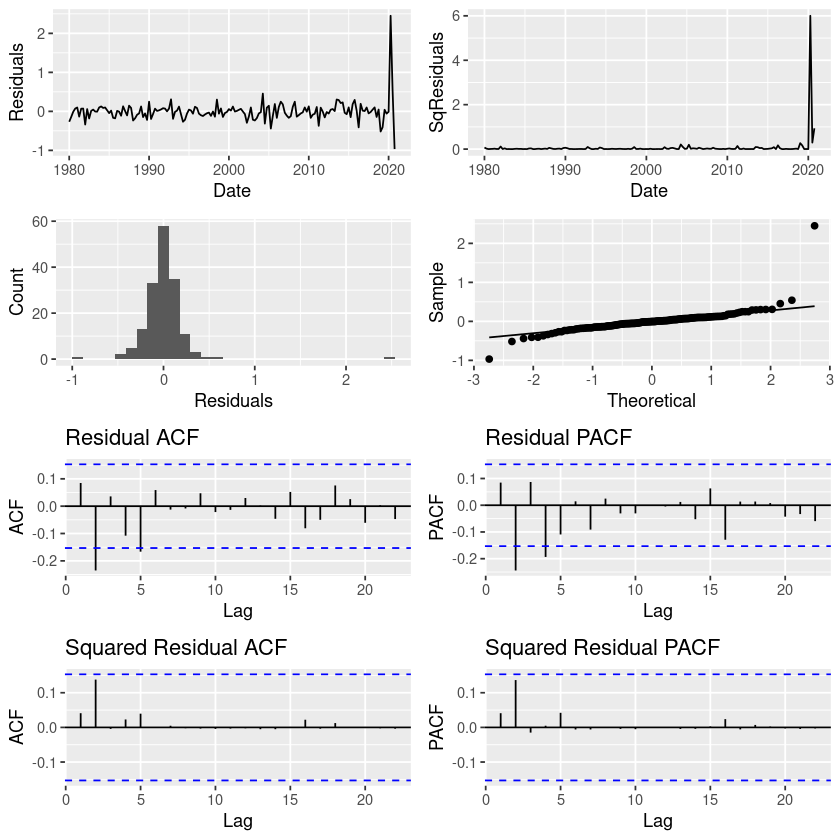

In [15]:
best_order2 <- ugarch_comp$Final[2,1:4] %>% as.numeric
spec2 <- ugarchspec(variance.model=list(garchOrder=c(best_order2[3:4])),
                     mean.model=list(armaOrder=c(best_order2[1:2]),
                                     include.mean=T), distribution.model="std")
ugarch_model2 <- ugarchfit(spec2, splines_residuals$Residuals, solver = 'hybrid', out.sample = test_split)
residual_analysis(ugarch_model2, train$Date)
box_tests(ugarch_model2, sum(best_order))

# Forecasting

## ARIMA

PM =  1.8289

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.1777959,0.3867724,0.3798162,57.41869,81.13959


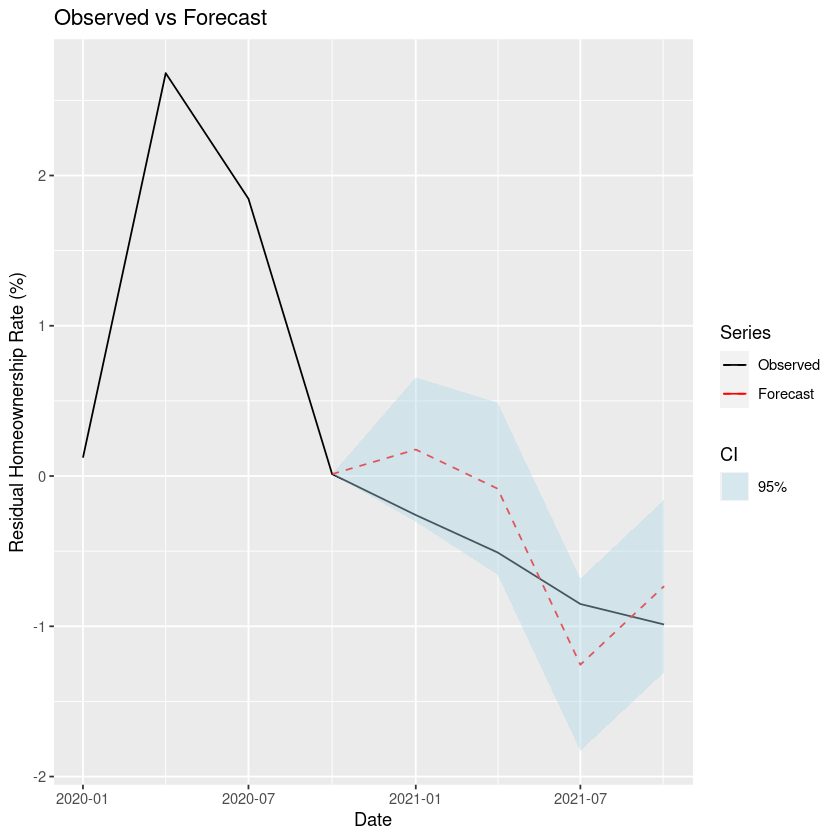

In [16]:
arima_fc <- forecast_arima(arima_model, splines_residuals$Date, splines_residuals$Residuals, test_split, 95,
                    y_lab = "Residual Homeownership Rate (%)")
arima_fc$plot
fc_data <- tail(arima_fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

## ARMA-GARCH: Model 1

PM =  0.2112353

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.01570997,0.1314449,0.1234891,-9.792685,24.60368


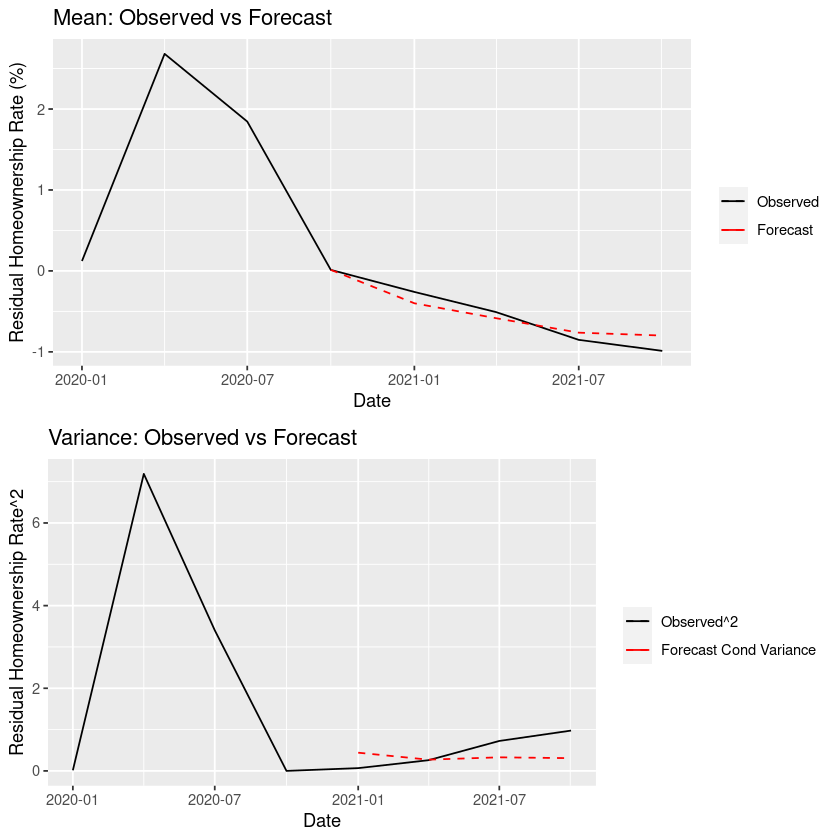

In [20]:
ugarch1_fc <- forecast_ugarchroll(ugarch_model1, splines_residuals$Date, test$Residuals, test_split,
                          y_lab = c("Residual Homeownership Rate (%)", "Residual Homeownership Rate^2"))
ugarch1_fc$plot
fc_data <- tail(ugarch1_fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

## ARMA-GARCH: Model 2

PM =  0.126206

,ME,RMSE,MAE,MPE,MAPE
Test set,0.00828763,0.1016016,0.09708998,-10.93529,20.31785


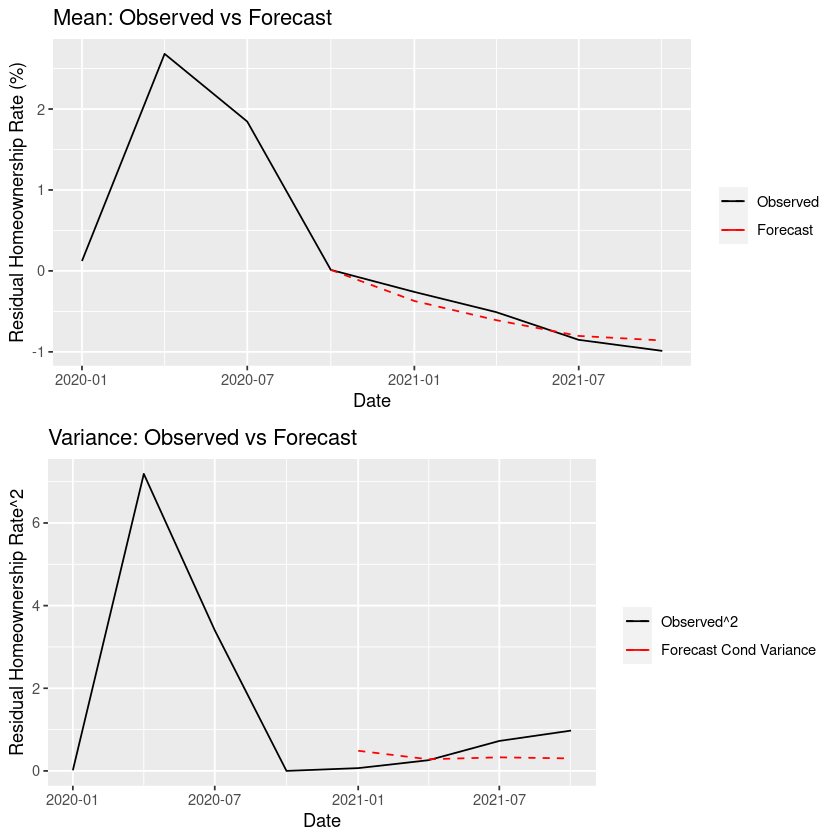

In [19]:
ugarch2_fc <- forecast_ugarchroll(ugarch_model2, splines_residuals$Date, test$Residuals, test_split,
                          y_lab = c("Residual Homeownership Rate (%)", "Residual Homeownership Rate^2"))
ugarch2_fc$plot
fc_data <- tail(ugarch2_fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

## Combined Model

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.6519867,0.7119555,0.6519867,-0.9960261,0.9960261


,ME,RMSE,MAE,MPE,MAPE
Test set,-0.1777959,0.3867724,0.3798162,-0.2708565,0.579756


,ME,RMSE,MAE,MPE,MAPE
Test set,-0.01570997,0.1314449,0.1234891,-0.02427259,0.18857


,ME,RMSE,MAE,MPE,MAPE
Test set,0.00828763,0.1016016,0.09708998,0.0124266,0.14821


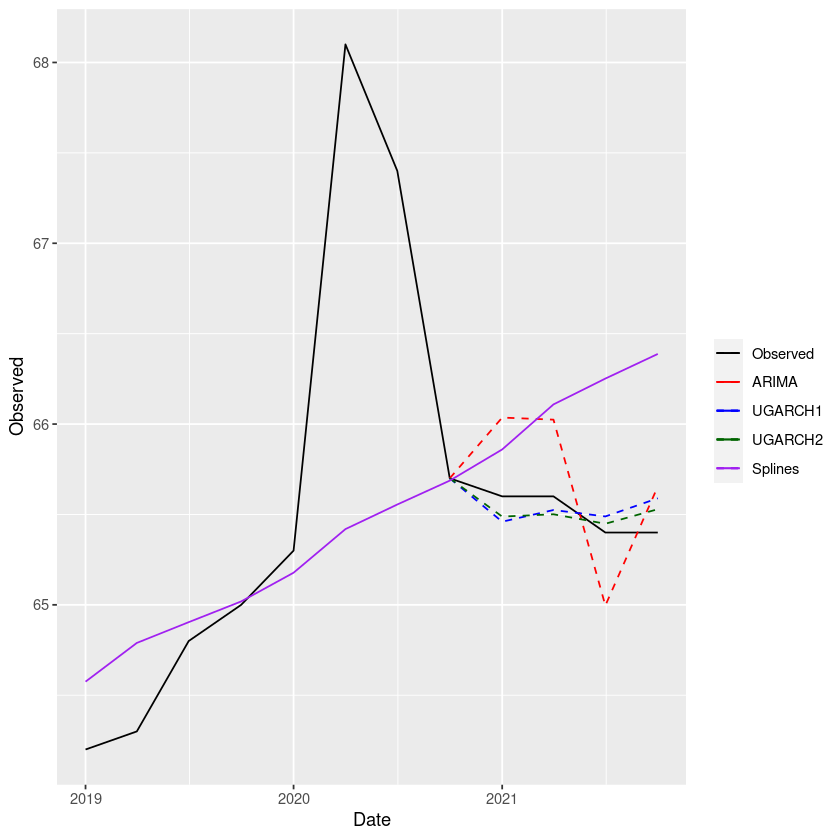

In [22]:
combined_fc <- data.frame(Date = head(homeownership$Date, -test_split),
                          Observed = head(homeownership$Value, -test_split),
                          ARIMA = rep(NA, nrow(train)), 
                          UGARCH1 = rep(NA, nrow(train)),
                          UGARCH2 = rep(NA, nrow(train)))
combined_fc$ARIMA[nrow(combined_fc)] <- combined_fc$Observed[nrow(combined_fc)]
combined_fc$UGARCH1[nrow(combined_fc)] <- combined_fc$Observed[nrow(combined_fc)]
combined_fc$UGARCH2[nrow(combined_fc)] <- combined_fc$Observed[nrow(combined_fc)]

splines_predict <- fitted(splines_model) %>% tail(test_split)
tmp <- data.frame(Date = tail(homeownership$Date, test_split),
                  Observed = tail(homeownership$Value, test_split),
                  ARIMA = tail(arima_fc$data$Forecast, test_split) + splines_predict,
                  UGARCH1 = tail(ugarch1_fc$data$Forecast, test_split) + splines_predict,
                  UGARCH2 = tail(ugarch2_fc$data$Forecast, test_split) + splines_predict)
combined_fc <- combined_fc %>% rbind(tmp)
combined_fc <- cbind(combined_fc, Splines = fitted(splines_model))

combined_fc %>% tail(12) %>% ggplot() +
  geom_line(aes(x = Date, y = Observed, color = "Observed")) +
  geom_line(aes(x = Date, y = ARIMA, color = "ARIMA"), linetype = "dashed") +
  geom_line(aes(x = Date, y = UGARCH1, color = "UGARCH1"), linetype = "dashed") +
  geom_line(aes(x = Date, y = UGARCH2, color = "UGARCH2"), linetype = "dashed") +
  geom_line(aes(x = Date, y = Splines, color = "Splines")) +
  scale_color_manual("", values = c("Observed" = "black", "ARIMA" = "red",
                                    "UGARCH1" = "blue", "UGARCH2" = "darkgreen",
                                    "Splines" = "purple"))

fc_only <- tail(combined_fc, test_split)
# cat("Splines Only MAPE =", mape(fc_only$Observed, fc_only$Splines), "\n")
# cat("Splines Only PM =", prec_measure(fc_only$Observed, fc_only$Splines), 
#     "\n-----------------------------\n")
# cat("ARIMA MAPE =", mape(fc_only$Observed, fc_only$ARIMA), "\n")
# cat("ARIMA PM =", prec_measure(fc_only$Observed, fc_only$ARIMA), 
#     "\n-----------------------------\n")
# cat("UGARCH1 MAPE =", mape(fc_only$Observed, fc_only$UGARCH1), "\n")
# cat("UGARCH1 PM = ", prec_measure(fc_only$Observed, fc_only$UGARCH1), 
#     "\n-----------------------------\n")
# cat("UGARCH2 MAPE =", mape(fc_only$Observed, fc_only$UGARCH2), "\n")
# cat("UGARCH2 PM =", prec_measure(fc_only$Observed, fc_only$UGARCH2), 
#     "\n-----------------------------\n")

accuracy(fc_only$Splines, x = fc_only$Observed)
accuracy(fc_only$ARIMA, x = fc_only$Observed)
accuracy(fc_only$UGARCH1, x = fc_only$Observed)
accuracy(fc_only$UGARCH2, x = fc_only$Observed)    
